In [37]:
# =============================================================================
# GPU MEMORY CLEANUP - Run this first to ensure clean state
# =============================================================================

import torch
import gc
import psutil
import os

def clear_gpu_memory():
    """Clear all GPU memory and run garbage collection"""
    print("🧹 Clearing GPU memory...")
    
    # Force garbage collection
    gc.collect()
    
    # Clear CUDA cache if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        
        # Get GPU memory info
        for i in range(torch.cuda.device_count()):
            gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1024**3
            allocated = torch.cuda.memory_allocated(i) / 1024**3
            cached = torch.cuda.memory_reserved(i) / 1024**3
            print(f"   GPU {i}: {allocated:.2f}GB allocated, {cached:.2f}GB cached of {gpu_memory:.2f}GB total")
        
        # Clear again after getting info
        torch.cuda.empty_cache()
        print("   ✅ CUDA cache cleared")
    else:
        print("   ⚠️  CUDA not available")
    
    # Get system memory info
    memory = psutil.virtual_memory()
    print(f"   💾 System RAM: {memory.used / 1024**3:.2f}GB used of {memory.total / 1024**3:.2f}GB total")
    
    print("   🗑️  Garbage collection completed")
    print("=" * 60)

# Clear memory at startup
clear_gpu_memory()

# Optional: Set memory management flags
if torch.cuda.is_available():
    # Prevent memory fragmentation
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
    print("🔧 PyTorch CUDA memory management configured")
    print("=" * 60)

# check if models are loaded and discard them if so
if 'llama3_model' in globals():
    del llama3_model
    gc.collect()
    torch.cuda.empty_cache()

if 'llada_model' in globals():
    del llada_model
    gc.collect()
    torch.cuda.empty_cache()

🧹 Clearing GPU memory...
   GPU 0: 0.03GB allocated, 0.03GB cached of 79.10GB total
   ✅ CUDA cache cleared
   💾 System RAM: 90.76GB used of 2015.47GB total
   🗑️  Garbage collection completed
🔧 PyTorch CUDA memory management configured


In [38]:
import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
import gc # For garbage collection
from vllm import LLM, SamplingParams

# --- Configuration ---
LLADA_MODEL_NAME = "GSAI-ML/LLaDA-8B-Instruct"
LLAMA3_MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Load Tokenizers ---
print("Loading tokenizers...")
llada_tokenizer = AutoTokenizer.from_pretrained(LLADA_MODEL_NAME, trust_remote_code=True)
llama3_tokenizer = AutoTokenizer.from_pretrained(LLAMA3_MODEL_NAME)

# Add a padding token to Llama3 tokenizer if it doesn't exist
if llama3_tokenizer.pad_token is None:
    llama3_tokenizer.pad_token = llama3_tokenizer.eos_token
# Note: The model config for pad_token_id will be set when the model is loaded.
    
print(f"Tokenizers loaded. Models will be loaded on-demand to save memory.")
print(f"Using device: {DEVICE}")


Loading tokenizers...


Tokenizers loaded. Models will be loaded on-demand to save memory.
Using device: cuda


In [39]:
# =============================================================================
# GENERATION PARAMETERS CONFIGURATION
# =============================================================================
"""
Configure generation parameters for both models here. 
This allows easy experimentation with different settings.
"""

# --- LLaDA Generation Parameters ---
LLADA_CONFIG = {
    # Core diffusion parameters
    'block_length': 8,         # Number of tokens to process in each block
    'steps': 4,                # Number of diffusion steps per block (increased for faithful implementation)
    'mask_id': 126336,          # Token ID for [MASK] token in LLaDA
    
    # Sampling strategy (for faithful diffusion)
    'temperature': 0.0,         # Sampling temperature (0.0 = deterministic, >0.0 = stochastic)
    'remasking': 'low_confidence', # Remasking strategy ('low_confidence' or 'random')
    'cfg_scale': 0.0,          # Classifier-free guidance scale (0.0 = disabled for speed)
    
    # Legacy parameters (kept for compatibility)
    'use_greedy': True,         # Use greedy decoding (deterministic) - mapped to temperature=0.0
    'confidence_threshold': 0.5, # Minimum confidence for token selection
    'top_k': 50,               # Top-k sampling (not used in faithful implementation)
    'top_p': 0.9,              # Top-p (nucleus) sampling (not used in faithful implementation)
}

# --- Llama3/vLLM Generation Parameters ---
LLAMA3_CONFIG = {
    # Core generation parameters
    'temperature': 0.0,         # 0.0 = greedy, >0.0 = sampling
    'top_k': -1,                # Top-k sampling (-1 = disabled)
    'top_p': 1.0,               # Top-p (nucleus) sampling (1.0 = disabled)
    'repetition_penalty': 1.0,  # Penalty for repeating tokens
    
    # Advanced parameters
    'frequency_penalty': 0.0,   # Penalty for frequent tokens
    'presence_penalty': 0.0,    # Penalty for tokens that have appeared
    'min_tokens': 0,           # Minimum number of tokens to generate
    'stop_sequences': None,     # List of strings that stop generation (None = disabled)
    
    # vLLM specific
    'n': 1,                    # Number of completions to generate
    'best_of': 1,              # Number of candidates to generate and return best
}

# --- Benchmarking Parameters ---
BENCHMARK_CONFIG = {
    'prompt_text': "Explain the theory of general relativity in a few paragraphs.",
    'generation_lengths': [512, 768, 1024],  # Token lengths to benchmark
    'num_trials': 1,                          # Number of trials per benchmark
    'show_generated_text': True,              # Whether to display generated text during benchmarks
    'gpu_memory_utilization': 0.9,           # GPU memory limit for vLLM (0.0-1.0)
}

print("✅ Generation parameters configured:")
print(f"   LLaDA: {LLADA_CONFIG['steps']} steps/block, {LLADA_CONFIG['block_length']} block length, temp={LLADA_CONFIG['temperature']}")
print(f"   Llama3: temp={LLAMA3_CONFIG['temperature']}, top_p={LLAMA3_CONFIG['top_p']}")
print(f"   Benchmark: {len(BENCHMARK_CONFIG['generation_lengths'])} lengths, {BENCHMARK_CONFIG['num_trials']} trials each")


✅ Generation parameters configured:
   LLaDA: 4 steps/block, 8 block length, temp=0.0
   Llama3: temp=0.0, top_p=1.0
   Benchmark: 3 lengths, 1 trials each


In [40]:
# =============================================================================
# FAITHFUL LLaDA DIFFUSION IMPLEMENTATION
# =============================================================================
"""
Faithful implementation of LLaDA diffusion language model based on generation.ipynb.
This replaces the problematic simple generation that was producing repetitive text.
"""

import torch.nn.functional as F
import numpy as np

def add_gumbel_noise(logits, temperature):
    '''
    The Gumbel max is a method for sampling categorical distributions.
    According to arXiv:2409.02908, for MDM, low-precision Gumbel Max improves perplexity score but reduces generation quality.
    Thus, we use float64.
    '''
    if temperature == 0:
        return logits
    logits = logits.to(torch.float64)
    noise = torch.rand_like(logits, dtype=torch.float64)
    gumbel_noise = (- torch.log(noise)) ** temperature
    return logits.exp() / gumbel_noise

@torch.no_grad()
def get_num_transfer_tokens(mask_index, steps):
    '''
    In the reverse process, the interval [0, 1] is uniformly discretized into steps intervals.
    Furthermore, because LLaDA employs a linear noise schedule (as defined in Eq. (8)),
    the expected number of tokens transitioned at each step should be consistent.

    This function is designed to precompute the number of tokens that need to be transitioned at each step.
    '''
    mask_num = mask_index.sum(dim=1, keepdim=True)

    base = mask_num // steps
    remainder = mask_num % steps

    num_transfer_tokens = torch.zeros(mask_num.size(0), steps, device=mask_index.device, dtype=torch.int64) + base

    for i in range(mask_num.size(0)):
        num_transfer_tokens[i, :remainder[i]] += 1

    return num_transfer_tokens

@torch.no_grad()
def generate(model, prompt, steps=128, gen_length=128, block_length=128, temperature=0.,
             cfg_scale=0., remasking='low_confidence', mask_id=126336):
    '''
    Faithful LLaDA diffusion generation function.
    
    Args:
        model: Mask predictor.
        prompt: A tensor of shape (1, L).
        steps: Sampling steps, less than or equal to gen_length.
        gen_length: Generated answer length.
        block_length: Block length, less than or equal to gen_length. If less than gen_length, it means using semi_autoregressive remasking.
        temperature: Categorical distribution sampling temperature.
        cfg_scale: Unsupervised classifier-free guidance scale.
        remasking: Remasking strategy. 'low_confidence' or 'random'.
        mask_id: The token id of [MASK] is 126336.
    '''
    x = torch.full((1, prompt.shape[1] + gen_length), mask_id, dtype=torch.long).to(model.device)
    x[:, :prompt.shape[1]] = prompt.clone()

    prompt_index = (x != mask_id)

    assert gen_length % block_length == 0
    num_blocks = gen_length // block_length

    assert steps % num_blocks == 0
    steps = steps // num_blocks

    for num_block in range(num_blocks):
        block_mask_index = (x[:, prompt.shape[1] + num_block * block_length: prompt.shape[1] + (num_block + 1) * block_length:] == mask_id)
        num_transfer_tokens = get_num_transfer_tokens(block_mask_index, steps)
        for i in range(steps):
            mask_index = (x == mask_id)
            if cfg_scale > 0.:
                un_x = x.clone()
                un_x[prompt_index] = mask_id
                x_ = torch.cat([x, un_x], dim=0)
                logits = model(x_).logits
                logits, un_logits = torch.chunk(logits, 2, dim=0)
                logits = un_logits + (cfg_scale + 1) * (logits - un_logits)
            else:
                logits = model(x).logits

            logits_with_noise = add_gumbel_noise(logits, temperature=temperature)
            x0 = torch.argmax(logits_with_noise, dim=-1) # b, l

            if remasking == 'low_confidence':
                p = F.softmax(logits, dim=-1)
                x0_p = torch.squeeze(
                    torch.gather(p, dim=-1, index=torch.unsqueeze(x0, -1)), -1) # b, l
            elif remasking == 'random':
                x0_p = torch.rand((x0.shape[0], x0.shape[1]), device=x0.device)
            else:
                raise NotImplementedError(remasking)

            x0_p[:, prompt.shape[1] + (num_block + 1) * block_length:] = -np.inf

            x0 = torch.where(mask_index, x0, x)
            confidence = torch.where(mask_index, x0_p, -np.inf)

            transfer_index = torch.zeros_like(x0, dtype=torch.bool, device=x0.device)
            for j in range(confidence.shape[0]):
                _, select_index = torch.topk(confidence[j], k=num_transfer_tokens[j, i])
                transfer_index[j, select_index] = True
            x[transfer_index] = x0[transfer_index]

    return x

@torch.no_grad()
def llada_generate_faithful(model, tokenizer, prompt_text, gen_length=512, config=None):
    """
    Faithful LLaDA generation function using proper diffusion process.
    Uses LLADA_CONFIG by default, but can be overridden with custom config.
    
    This function replaces the problematic llada_generate_simple and implements
    the full diffusion process for high-quality generation.
    """
    if config is None:
        config = LLADA_CONFIG
    
    # Extract parameters from config
    block_length = config.get('block_length', 128)
    steps = config.get('steps', 4)
    mask_id = config.get('mask_id', 126336)
    temperature = config.get('temperature', 0.0)
    
    # Map config parameters to diffusion function parameters
    # For benchmarking, we use low_confidence remasking for deterministic results
    remasking = 'low_confidence'
    cfg_scale = 0.0  # No CFG for speed benchmarking
    
    # Format prompt for instruct model
    messages = [{"role": "user", "content": prompt_text}]
    formatted_prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    input_ids = tokenizer(formatted_prompt, return_tensors="pt")['input_ids'].to(DEVICE)
    
    # Ensure gen_length is divisible by block_length for proper diffusion
    if gen_length % block_length != 0:
        # Adjust gen_length to be divisible by block_length
        gen_length = ((gen_length + block_length - 1) // block_length) * block_length
        print(f"  ⚠️  Adjusted gen_length to {gen_length} to be divisible by block_length ({block_length})")
    
    # Generate using faithful diffusion process
    output = generate(
        model=model,
        prompt=input_ids,
        steps=steps * (gen_length // block_length),  # Total steps for all blocks
        gen_length=gen_length,
        block_length=block_length,
        temperature=temperature,
        cfg_scale=cfg_scale,
        remasking=remasking,
        mask_id=mask_id
    )
    
    # Decode only the generated part (excluding input)
    generated_text = tokenizer.batch_decode(output[:, input_ids.shape[1]:], skip_special_tokens=True)[0]
    
    return generated_text

print("✅ Faithful LLaDA diffusion implementation loaded:")
print("   📦 add_gumbel_noise() - Proper Gumbel sampling")
print("   📦 get_num_transfer_tokens() - Linear noise schedule")
print("   📦 generate() - Full diffusion process")
print("   📦 llada_generate_faithful() - Configured wrapper")


✅ Faithful LLaDA diffusion implementation loaded:
   📦 add_gumbel_noise() - Proper Gumbel sampling
   📦 get_num_transfer_tokens() - Linear noise schedule
   📦 generate() - Full diffusion process
   📦 llada_generate_faithful() - Configured wrapper


In [41]:
@torch.no_grad()
def llama3_generate(model, tokenizer, prompt_text, gen_length=512):
    """
    Standard autoregressive generation for Llama3.
    """
    messages = [{"role": "user", "content": prompt_text}]
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(DEVICE)
    
    # Generate text
    outputs = model.generate(
        input_ids,
        max_new_tokens=gen_length,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False  # Use greedy decoding for speed comparison
    )
    
    # Decode the generated tokens
    response = outputs[0][input_ids.shape[-1]:]
    return tokenizer.decode(response, skip_special_tokens=True)

print("Llama3 generation function loaded.")


Llama3 generation function loaded.


In [42]:
def vllm_generate(model, tokenizer, prompt_text, gen_length=512, config=None):
    """
    Generates text using the vLLM engine with configurable parameters.
    Uses LLAMA3_CONFIG by default, but can be overridden with custom config.
    """
    if config is None:
        config = LLAMA3_CONFIG
    
    # The tokenizer is used for creating the prompt, but vLLM handles tokenization internally
    messages = [{"role": "user", "content": prompt_text}]
    prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    
    # Extract parameters with proper validation
    temperature = config.get('temperature', 0.0)
    top_k = config.get('top_k', -1)
    top_p = config.get('top_p', 1.0)
    n = config.get('n', 1)
    best_of = config.get('best_of', 1)
    
    # Ensure best_of >= n (required by vLLM)
    if best_of < n:
        best_of = n
    
    # Handle stop sequences properly
    stop_sequences = config.get('stop_sequences')
    if stop_sequences == [] or stop_sequences is None:
        stop_sequences = None
    
    # Create sampling parameters with only supported parameters
    try:
        sampling_params = SamplingParams(
            n=n,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=config.get('repetition_penalty', 1.0),
            frequency_penalty=config.get('frequency_penalty', 0.0),
            presence_penalty=config.get('presence_penalty', 0.0),
            max_tokens=gen_length,
            min_tokens=config.get('min_tokens', 0),
            stop=stop_sequences,
            best_of=best_of,
        )
    except TypeError as e:
        # Fallback for older vLLM versions with fewer parameters
        print(f"⚠️  Parameter not supported in this vLLM version, using basic parameters: {e}")
        sampling_params = SamplingParams(
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            max_tokens=gen_length,
            stop=stop_sequences,
        )
    
    # Generate text
    outputs = model.generate(prompt, sampling_params)
    
    # Return the generated text from the first output
    return outputs[0].outputs[0].text

print("vLLM generation function loaded.")


vLLM generation function loaded.


In [43]:
# --- Benchmarking Framework ---
# Extract parameters from BENCHMARK_CONFIG
PROMPT_TEXT = BENCHMARK_CONFIG['prompt_text']
GENERATION_LENGTHS = BENCHMARK_CONFIG['generation_lengths']
NUM_TRIALS = BENCHMARK_CONFIG['num_trials']

def run_benchmark(model_name, gen_function, tokenizer, gen_length, print_text=False, **kwargs):
    """
    Runs the generation benchmark for a given model and returns timing statistics.
    """
    total_time = 0
    total_tokens = 0
    generated_texts = []
    
    # Warm-up run
    print(f"  Warm-up run for {gen_length} tokens...")
    gen_function(
        model=kwargs.get('model'), 
        tokenizer=tokenizer, 
        prompt_text=PROMPT_TEXT, 
        gen_length=gen_length,
        **kwargs.get('func_args', {})
    )
    torch.cuda.synchronize()

    # Timed trials
    for i in range(NUM_TRIALS):
        print(f"  Trial {i+1}/{NUM_TRIALS} for {gen_length} tokens...")
        start_time = time.time()
        
        generated_text = gen_function(
            model=kwargs.get('model'), 
            tokenizer=tokenizer, 
            prompt_text=PROMPT_TEXT, 
            gen_length=gen_length,
            **kwargs.get('func_args', {})
        )
        
        torch.cuda.synchronize()
        end_time = time.time()
        
        elapsed_time = end_time - start_time
        num_tokens = len(tokenizer.encode(generated_text))
        
        total_time += elapsed_time
        total_tokens += num_tokens
        generated_texts.append(generated_text)
        
        # Print generated text if requested
        if print_text:
            print(f"    📝 Generated Text (Trial {i+1}):")
            print(f"    {'-' * 50}")
            print(f"    {generated_text[:200]}{'...' if len(generated_text) > 200 else ''}")
            print(f"    {'-' * 50}")
            print(f"    Tokens: {num_tokens}, Time: {elapsed_time:.2f}s")
            print()

    avg_time = total_time / NUM_TRIALS
    avg_tokens = total_tokens / NUM_TRIALS
    tokens_per_sec = avg_tokens / avg_time if avg_time > 0 else 0
    
    result = {
        "Model": model_name,
        "Gen Length": gen_length,
        "Avg Time (s)": avg_time,
        "Avg Tokens": avg_tokens,
        "Tokens/Sec": tokens_per_sec
    }
    
    # Add generated texts to result if requested
    if print_text:
        result["Generated_Texts"] = generated_texts
    
    return result

print("Benchmarking framework loaded.")


Benchmarking framework loaded.


In [44]:
# --- Run Benchmarks ---
results_list = []

# --- LLaDA Benchmark ---
print(f"Loading LLaDA model: {LLADA_MODEL_NAME}...")
llada_model = AutoModel.from_pretrained(
    LLADA_MODEL_NAME, 
    trust_remote_code=True, 
    torch_dtype=torch.bfloat16
).to(DEVICE).eval()
print("LLaDA model loaded.")

# Use configuration instead of hardcoded parameters
for i, length in enumerate(GENERATION_LENGTHS):
    print(f"\\n{'='*20} Benchmarking LLaDA for {length} tokens {'='*20}")
    print(f"📋 Config: {LLADA_CONFIG['steps']} steps/block, {LLADA_CONFIG['block_length']} block_length, temp={LLADA_CONFIG['temperature']}")
    
    # Print text based on configuration
    show_text = BENCHMARK_CONFIG['show_generated_text'] and (i == 0)
    if show_text:
        print("📝 Showing generated texts for this length...")
    
    llada_results = run_benchmark(
        "LLaDA-8B",
        llada_generate_faithful,
        llada_tokenizer,
        length,
        print_text=show_text,
        model=llada_model,
        func_args={'config': LLADA_CONFIG}  # Pass the entire config
    )
    results_list.append(llada_results)

# Clear LLaDA model from memory
print("\\nClearing LLaDA model from memory...")
del llada_model
gc.collect()
torch.cuda.empty_cache()
print("LLaDA model cleared.")

Loading LLaDA model: GSAI-ML/LLaDA-8B-Instruct...


Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00, 228.52it/s]


LLaDA model loaded.
\n==================== Benchmarking LLaDA for 512 tokens ====================
📋 Config: 4 steps/block, 8 block_length, temp=0.0
📝 Showing generated texts for this length...
  Warm-up run for 512 tokens...
  Trial 1/1 for 512 tokens...
    📝 Generated Text (Trial 1):
    --------------------------------------------------
    The theory of general relativity, proposed by Albert Einstein in 1915, is a framework of grav physics that describes the effects of mass and energy. It to the Newtonian theory of gravity, which pos th...
    --------------------------------------------------
    Tokens: 162, Time: 5.77s

\n==================== Benchmarking LLaDA for 768 tokens ====================
📋 Config: 4 steps/block, 8 block_length, temp=0.0
  Warm-up run for 768 tokens...
  Trial 1/1 for 768 tokens...
\n==================== Benchmarking LLaDA for 1024 tokens ====================
📋 Config: 4 steps/block, 8 block_length, temp=0.0
  Warm-up run for 1024 tokens...
  Trial 1/1 f

In [45]:
# --- Llama3 vLLM Benchmark ---
print(f"\\nLoading Llama3 model with vLLM: {LLAMA3_MODEL_NAME}...")
# vLLM handles device placement automatically
# Use GPU memory utilization from config
llama3_model = LLM(
    model=LLAMA3_MODEL_NAME, 
    trust_remote_code=True,
    gpu_memory_utilization=BENCHMARK_CONFIG['gpu_memory_utilization']
)
print("Llama3 vLLM model loaded.")

for i, length in enumerate(GENERATION_LENGTHS):
    print(f"\\n{'='*20} Benchmarking Llama3 (vLLM) for {length} tokens {'='*20}")
    print(f"📋 Config: temp={LLAMA3_CONFIG['temperature']}, top_p={LLAMA3_CONFIG['top_p']}, rep_penalty={LLAMA3_CONFIG['repetition_penalty']}")
    
    # Print text based on configuration
    show_text = BENCHMARK_CONFIG['show_generated_text'] and (i == 0)
    if show_text:
        print("📝 Showing generated texts for this length...")
    
    llama3_results = run_benchmark(
        "Llama-3-8B (vLLM)",
        vllm_generate,
        llama3_tokenizer,
        length,
        print_text=show_text,
        model=llama3_model,
        func_args={'config': LLAMA3_CONFIG}  # Pass the entire config
    )
    results_list.append(llama3_results)

# Clear Llama3 model from memory
print("\\nClearing Llama3 model from memory...")
del llama3_model
gc.collect()
torch.cuda.empty_cache()
print("Llama3 model cleared.")

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results_list)

print("\\nBenchmark Complete!")

\nLoading Llama3 model with vLLM: meta-llama/Meta-Llama-3-8B-Instruct...


INFO 08-13 19:18:29 [config.py:793] This model supports multiple tasks: {'embed', 'generate', 'score', 'reward', 'classify'}. Defaulting to 'generate'.
INFO 08-13 19:18:29 [config.py:2118] Chunked prefill is enabled with max_num_batched_tokens=16384.
INFO 08-13 19:18:34 [__init__.py:243] Automatically detected platform cuda.
INFO 08-13 19:18:37 [core.py:438] Waiting for init message from front-end.
INFO 08-13 19:18:37 [__init__.py:31] Available plugins for group vllm.general_plugins:
INFO 08-13 19:18:37 [__init__.py:33] - lora_filesystem_resolver -> vllm.plugins.lora_resolvers.filesystem_resolver:register_filesystem_resolver
INFO 08-13 19:18:37 [__init__.py:36] All plugins in this group will be loaded. Set `VLLM_PLUGINS` to control which plugins to load.
INFO 08-13 19:18:37 [core.py:65] Initializing a V1 LLM engine (v0.9.0) with config: model='meta-llama/Meta-Llama-3-8B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3-8B-Instruct', skip_tokenizer_init=False, token

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  5.89it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:00<00:01,  1.95it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.53it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.39it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.56it/s]



INFO 08-13 19:18:48 [default_loader.py:280] Loading weights took 2.66 seconds
INFO 08-13 19:18:48 [gpu_model_runner.py:1549] Model loading took 14.9596 GiB and 10.205927 seconds
INFO 08-13 19:18:53 [backends.py:459] Using cache directory: /root/.cache/vllm/torch_compile_cache/8943ea9d20/rank_0_0 for vLLM's torch.compile
INFO 08-13 19:18:53 [backends.py:469] Dynamo bytecode transform time: 5.45 s
INFO 08-13 19:18:57 [backends.py:132] Directly load the compiled graph(s) for shape None from the cache, took 3.794 s
INFO 08-13 19:18:58 [monitor.py:33] torch.compile takes 5.45 s in total
INFO 08-13 19:18:59 [kv_cache_utils.py:637] GPU KV cache size: 409,744 tokens
INFO 08-13 19:18:59 [kv_cache_utils.py:640] Maximum concurrency for 8,192 tokens per request: 50.02x
INFO 08-13 19:19:14 [gpu_model_runner.py:1933] Graph capturing finished in 16 secs, took 0.65 GiB
INFO 08-13 19:19:14 [core.py:167] init engine (profile, create kv cache, warmup model) took 26.60 seconds
Llama3 vLLM model loaded.
\n

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 9.53 toks/s, output: 141.34 toks/s]


  Trial 1/1 for 512 tokens...


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 9.55 toks/s, output: 142.06 toks/s]


    📝 Generated Text (Trial 1):
    --------------------------------------------------
    The theory of general relativity, proposed by Albert Einstein in 1915, is a fundamental concept in modern physics that revolutionized our understanding of space, time, and gravity. In a nutshell, gene...
    --------------------------------------------------
    Tokens: 357, Time: 2.52s

\n==================== Benchmarking Llama3 (vLLM) for 768 tokens ====================
📋 Config: temp=0.0, top_p=1.0, rep_penalty=1.0
  Warm-up run for 768 tokens...


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 9.55 toks/s, output: 142.08 toks/s]


  Trial 1/1 for 768 tokens...


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 9.55 toks/s, output: 142.07 toks/s]


\n==================== Benchmarking Llama3 (vLLM) for 1024 tokens ====================
📋 Config: temp=0.0, top_p=1.0, rep_penalty=1.0
  Warm-up run for 1024 tokens...


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 9.55 toks/s, output: 142.09 toks/s]


  Trial 1/1 for 1024 tokens...


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 9.55 toks/s, output: 142.10 toks/s]


\nClearing Llama3 model from memory...


[rank0]:[W813 19:19:31.245135030 ProcessGroupNCCL.cpp:1476] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


Llama3 model cleared.
\nBenchmark Complete!


In [46]:
results_df

,Model,Gen Length,Avg Time (s),Avg Tokens,Tokens/Sec,Generated_Texts
0,LLaDA-8B,512,5.770715,162.0,28.072778,"[The theory of general relativity, proposed by..."
1,LLaDA-8B,768,11.481593,199.0,17.332090,NaN
2,LLaDA-8B,1024,20.115563,152.0,7.556338,NaN
3,Llama-3-8B (vLLM),512,2.516245,357.0,141.878096,"[The theory of general relativity, proposed by..."
4,Llama-3-8B (vLLM),768,2.516191,357.0,141.881148,NaN
5,Llama-3-8B (vLLM),1024,2.515387,357.0,141.926468,NaN


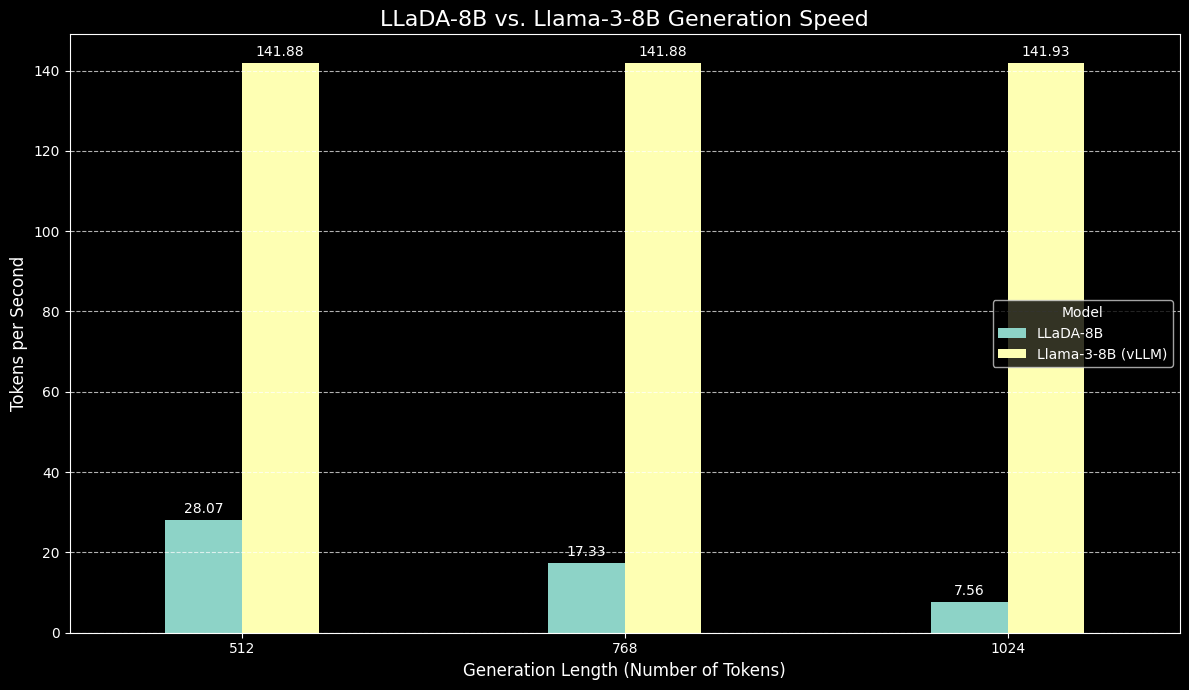

In [47]:
# --- Visualize Results ---
fig, ax = plt.subplots(figsize=(12, 7))

# Plotting the data
pivot_df = results_df.pivot(index='Gen Length', columns='Model', values='Tokens/Sec')
pivot_df.plot(kind='bar', ax=ax, width=0.4)

# Formatting the plot
ax.set_title('LLaDA-8B vs. Llama-3-8B Generation Speed', fontsize=16)
ax.set_xlabel('Generation Length (Number of Tokens)', fontsize=12)
ax.set_ylabel('Tokens per Second', fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.legend(title='Model')

# Adding labels on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10, padding=3)

plt.tight_layout()
plt.show()
